##### In this notebook another new model checkpoint intended for summarization is tested. This model is in the DistilBert category of transformers, which is designed to have much of the knwowledge and predictive power of the larger Bert class, with less space and processing power required. This should allow the finetuned model to function better than model 05.

# Imports

In [1]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read in data

In [3]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer
model: https://huggingface.co/sshleifer/distilbart-xsum-1-1

In [4]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Tokenize data

In [5]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=512, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=512, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [6]:
tokenized_data = data.map(preprocess_function)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7947db7e9ac627a0.arrow


0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-eea2a94d92f0349f.arrow


# Fine tune model

## Set up model

In [7]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [8]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [10]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [11]:
num_train_epochs = 10
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [12]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [13]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=10)

Epoch 1/10
212/212 [==============================] - 29s 82ms/step - loss: 5.6314 - val_loss: 5.0562
Epoch 2/10
212/212 [==============================] - 16s 74ms/step - loss: 4.8927 - val_loss: 4.8471
Epoch 3/10
212/212 [==============================] - 16s 73ms/step - loss: 4.5584 - val_loss: 4.7636
Epoch 4/10
212/212 [==============================] - 16s 73ms/step - loss: 4.3258 - val_loss: 4.7297
Epoch 5/10
212/212 [==============================] - 16s 74ms/step - loss: 4.1329 - val_loss: 4.6989
Epoch 6/10
212/212 [==============================] - 16s 73ms/step - loss: 3.9803 - val_loss: 4.7117
Epoch 7/10
212/212 [==============================] - 16s 74ms/step - loss: 3.8649 - val_loss: 4.7084
Epoch 8/10
212/212 [==============================] - 16s 73ms/step - loss: 3.7720 - val_loss: 4.7136
Epoch 9/10
212/212 [==============================] - 16s 73ms/step - loss: 3.7026 - val_loss: 4.7243
Epoch 10/10
212/212 [==============================] - 16s 74ms/step - loss: 3.659

# Visualize model

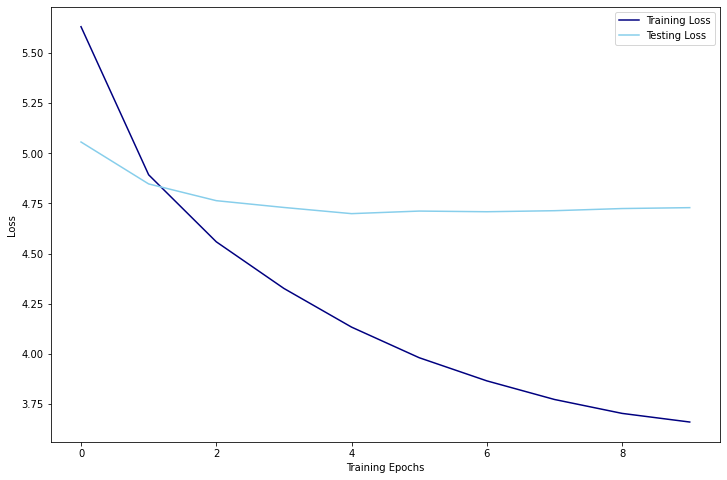

In [14]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is higher than the loss for the training data, indicating that the model is overfitting. However, the two loss functions at their value value are a bit closer together and seem to be growing apart less rapidly in this model than in model 5, indicating some improvement (although the final loss vale for the training data is higher than for model 5)

# Rouge scores for training data

In [64]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [38:36<00:00, 10.93s/it]


In [65]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 74.46808510638297
recall: 11.705685618729097
f-measure: 20.23121387283237
***************
rouge2
precision: 17.391304347826086
recall: 2.684563758389262
f-measure: 4.651162790697675
***************
rougeL
precision: 40.42553191489361
recall: 6.354515050167224
f-measure: 10.982658959537572
***************
rougeLsum
precision: 68.08510638297872
recall: 10.702341137123746
f-measure: 18.497109826589593
***************


# Rouge scores for test data

In [67]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [68]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [11:21<00:00, 11.56s/it]


In [69]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 55.769230769230774
recall: 12.663755458515283
f-measure: 20.640569395017792
***************
rouge2
precision: 13.725490196078432
recall: 3.070175438596491
f-measure: 5.017921146953405
***************
rougeL
precision: 32.69230769230769
recall: 7.423580786026202
f-measure: 12.09964412811388
***************
rougeLsum
precision: 44.230769230769226
recall: 10.043668122270741
f-measure: 16.370106761565836
***************


# Example model-generated summaries

In [73]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [74]:
print(rand_indexes)

[44, 36, 25]


In [75]:
#Reference summary example 1
print(test_labels[44])

Catherine tells Heathcliff that her father will be miserable if she does not return, and asks him to send Ellen to the Grange so he will know that she is safe.
He refuses.
She also offers to marry Linton now so that she may return, but he again refuses.
Soon it grows dark and servants come from the Grange looking for the two, but they are sent away.
Neither sleep that night, and in the morning, Heathcliff comes for Catherine, leaving Ellen locked in the housekeeper's room.
Hours later Hareton comes to bring Ellen food, but he will not help her.
Ellen is locked in the room for five nights and four days.
All are happy to see her when she arrives, and she goes to tell Mr. Linton that Catherine will be coming.
He finds it best to change his will so that Catherine will get his property and Heathcliff will not, and sends for his lawyer, Mr. Green.
Ellen sends four men to  to get Catherine.
The lawyer sends word that he cannot come now, but will soon come, and the four men return saying that 

In [76]:
#Model summary example 1
print(test_preds[44])

: : : Novel : 2.1 million pounds from Ellen to Linton, and Catherine will not be allowed to leave Linton.
He tells Ellen that Ellen that he has been struck by Ellen to find her father and daughter.
She tells her that she will not go to the house, and


In [77]:
#Reference summary example 2
print(test_labels[36])

The UM now uses an analogy to make his point.
He describes the normal, "stupid" person as an enraged bull rushing headlong into a wall at the slightest impulse.
He likens himself, one who possesses a hyperconsciousness, to a mouse-the antithesis of a normal man, he says.
While the bull acts on its rather simple mental reasoning, the mouse cannot act because its overly sophisticated mental processes perpetually plague it with doubt and vacillation, rendering him unable to do anything, save "creep ignominiously back into its mousehole."
This hole, this underground, is the home of the UM and those like him.
At the end of the chapter, the UM elaborates on the wall concept.
The wall represents, he explains, "the laws of nature, the conclusions of natural science and mathematics."
The wall also embodies such ideas as evolution, which Dostoevsky largely equated with atheism and socialism.
While the man of action readily accepts the wall and its implications, the UM (and Dostoevsky) can't come

In [78]:
#Model summary example 2
print(test_preds[36])

In this chapter, Mr. Lorry arrives at his house.


In [79]:
#Reference summary example 3
print(test_labels[25])

Katherine is sewing with her ladies-in-waiting.
She asks one of them to sing.
The woman sings a song about the power of music to heal sorrow.
A Gentleman enters and tells Katherine that the cardinals want to speak with her.
As Katherine asks him to show them in, she worries about what they want with her.
Wolsey and Campeius enter.
Wolsey asks her if they can speak in a private room, but she says that her conscience is clear, so she is happy to speak here.
Wolsey begins to speak to her in Latin, but she stops him, saying that it could make people think that there is something about her cause which must be hidden.
She asks him to speak in English, for all to hear.
Wolsey says that they have come not to accuse her, but to know her intentions in the matter of the divorce, and to give her advice and comfort.
Campeius says that Wolsey, out of nobility of spirit, has forgiven Katherine for her false accusations against him, and has come to offer help.
Katherine is not convinced, saying in an 

In [80]:
#Model summary example 3
print(test_preds[25])

The Queen tells her of her sister that she does not want her love, but she says she will not go to her housekeeper.
She tells her that she will take him back into the sea.
He tells him that she has been imprisoned for life.
He says that she is


# Evaluation of model

Based on rouge scores, this model did perform better than the three-sentence baseline model and the previous finetuned models. The example model-generted samples still are not very good from a subjective human standpoint, but they seem to make more sense and to be getting a little closer to the desired output than previous models. The highest f1-score is the rouge1, indicating that this model is better at outputting important unigrams, but is still struggling with longer text sequences